### Imports

In [1]:
# General
from collections import Counter
from tempfile import mkdtemp
from shutil import rmtree
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest, VarianceThreshold, f_classif)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer

# Custom
from data_io import read_data
from utils import label_map, normalize

In [2]:
%load_ext autoreload
%autoreload 2

## Load data

In [3]:
texts_train, labels_train = read_data(mode='train')
y_train_full = np.asarray([label_map[label] for label in labels_train])

In [4]:
texts_val, labels_val = read_data(mode='val')
y_val_full = np.asarray([label_map[label] for label in labels_val])

In [5]:
texts_test, labels_test = read_data(mode='test')
y_test_full = np.asarray([label_map[label] for label in labels_test])

#### Class distribution

<AxesSubplot:ylabel='count'>

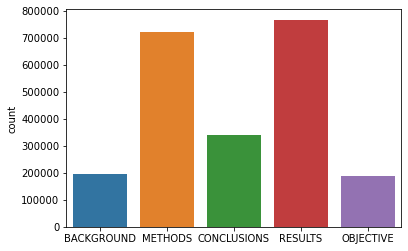

In [6]:
sns.countplot(x=labels_train)

## Preprocessing
- Clean end-of-line characters
- Lowercase
- Tokenize
- Stopwords removal
- Digit replacement

In [7]:
normalized_text_train = [normalize(doc, return_string=True) for doc in tqdm(texts_train)]
normalized_text_val = [normalize(doc, return_string=True) for doc in tqdm(texts_val)]
normalized_text_test = [normalize(doc, return_string=True) for doc in tqdm(texts_test)]

  0%|          | 0/2211861 [00:00<?, ?it/s]

  0%|          | 0/28932 [00:00<?, ?it/s]

  0%|          | 0/29493 [00:00<?, ?it/s]

## Pipeline
Setup an `sklearn` pipeline for hyperparameter search on the tf-idf cut-offs and the logistic regression regularization.

In [8]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    lowercase=False,
    # tokenizer = id, # tokenizer=lambda doc: doc,
    # max_features=1000,
    # ngram_range=(1,2)
)

In [9]:
# Logistic Regression
lr = LogisticRegression(
    max_iter=512,
    verbose=0,
    class_weight = "balanced",
    random_state = 42,
    multi_class = "multinomial",
    solver = "saga" # handles multinomial and l1
)

In [11]:
pipeline_steps = [
    ("tfidf", tfidf_vectorizer), # extract tf-idf features
    ("scaler", StandardScaler(with_mean=False)), # standardize, no normalization, tf-idf already outputs normalized values
#     ("var_thresh",  VarianceThreshold(threshold=1e-9)) # not used in final version
#     ("kbest", SelectKBest(f_classif, k=32000)) # not used in final version
    ("clf", lr)
]

# Major parameters for grid search
# pipeline_params = dict(
#     tfidf__max_df = [0.7, 0.8, 0.9, 0.95],
#     tfidf__min_df = [1e-5, 1e-4, 1e-2],
    
#     clf__C = [0.00001, 0.0001, 0.001, 0.01],
#     clf__penalty = ["l2"] # "l1"
# )

# Best configuration:
pipeline_params = dict(
    tfidf__max_df = [0.7],
    tfidf__min_df = [0.0001],
    
    clf__C = [0.01],
    clf__penalty = ["l2"] # "l1"
)

# build pipeline, use caching to improve performance of the grid search (requires a lot of memory)
cachedir = mkdtemp()
pipeline = Pipeline(pipeline_steps, memory=cachedir)

### Grid Search
Search hyperparameter space, choose best model based on 5-fold CV F1-micro scores and refit on all data

In [12]:
# combine training and validation set as we estimate scores using 5-fold stratified CV
texts_train_combined = np.concatenate((normalized_text_train, normalized_text_val))
labels_combined = np.concatenate((y_train_full, y_val_full))

In [13]:
# sample subset of data for testing and initial exploration
# sample = np.random.choice(len(texts_train_combined), size=1000, replace=False)
# texts_train_combined = texts_train_combined[sample]
# labels_combined = labels_combined[sample]

In [14]:
print(f"Train: {len(normalized_text_train)}, Val: {len(normalized_text_val)}, Combined: {len(texts_train_combined)}")

Train: 2211861, Val: 28932, Combined: 2240793


In [15]:
scoring_function = make_scorer(f1_score, average="micro")

In [16]:
pipeline_grid = GridSearchCV(
    estimator = pipeline,
    param_grid = pipeline_params,
    cv = 5, # does a stratified 5-fold by default
    n_jobs = 28,
    refit = True, # refit best configuration on all data
    scoring=scoring_function,
    return_train_score = True,
    verbose = 2
)

pipeline_grid.fit(texts_train_combined, labels_combined)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/burgerm/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/pipeline.py:303: UserWarning: Persisting input arguments took 18.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


GridSearchCV(cv=5,
             estimator=Pipeline(memory='/tmp/tmpdcfywk79',
                                steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False)),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=512,
                                                           multi_class='multinomial',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=28,
             param_grid={'clf__C': [0.01], 'clf__penalty': ['l2'],
                         'tfidf__max_df': [0.7], 'tfidf__min_df': [0.0001]},
             return_train_score=True,
             scoring=mak

In [17]:
print(f"Best CV: {pipeline_grid.best_score_:.4f} +/- {pipeline_grid.cv_results_['std_test_score'][pipeline_grid.best_index_]:.4f}, \
        Best Training: {pipeline_grid.cv_results_['mean_train_score'][pipeline_grid.best_index_]:.4f}")

Best CV: 0.7681 +/- 0.0004,         Best Training: 0.7774


In [18]:
print("Best Params", pipeline_grid.best_params_)

Best Params {'clf__C': 0.01, 'clf__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__min_df': 0.0001}


### Evaluation
Report F1 (micro) score on the test data

In [19]:
y_pred_test = pipeline_grid.predict(normalized_text_test)

In [21]:
score_micro = f1_score(y_test_full, y_pred_test, average="micro")
score_w = f1_score(y_test_full, y_pred_test, average="weighted")
print(f"F1 Score on Test: {score_micro:.4f} (micro), {score_w:.4f} (weighted)")

F1 Score on Test: 0.7706 (micro), 0.7742 (weighted)


#### Store Predictions

In [22]:
y_pred_train = pipeline_grid.predict(normalized_text_train)
y_pred_val = pipeline_grid.predict(normalized_text_val)
y_pred_test = pipeline_grid.predict(normalized_text_test)

In [23]:
np.save("./predictions/train_tfidf_logreg", y_pred_train, allow_pickle=True)
np.save("./predictions/val_tfidf_logreg", y_pred_val, allow_pickle=True)
np.save("./predictions/test_tfidf_logreg", y_pred_test, allow_pickle=True)

### Cleanup
Remove pipeline caching temp. directory

In [ ]:
# Clear the cache directory when you don't need it anymore
rmtree(cachedir)